In [1]:
# import the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import chi2_contingency
import math
from math import sqrt
import shap
from geopy.distance import geodesic

from feature_engine.outliers import Winsorizer
from feature_engine.transformation import LogTransformer, ReciprocalTransformer, PowerTransformer, BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder, CountFrequencyEncoder, MeanEncoder, RareLabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import f_classif, chi2, f_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

<a id= "Start"></a>

## Table of Contents
### 1. [HR Analytics](#part1)
    
   - [1.1 Load Data into Jupyter Notebook](#part1.1)
   - [1.2 Exploratory Data Analysis](#part1.2)
   - [1.3 Chi-Square Test for Independence](#part1.3)
   - [1.4 Missing Value Imputation](#part1.4)
   - [1.5 Numerical Transformation](#part1.5)
   - [1.6 Categorical Data Encoding](#part1.6)
   - [1.7 Correlation Analysis](#part1.7)
   - [1.8 Feature Selection](#part1.8)
   - [1.9 Feature Scaling](#part1.9)
   - [1.10 Stratified Sampling](#part1.10)

<a id= "part1"></a>
## 1. HR Analytics

Getting promoted at work has its perks like more respect, better pay, and a higher status. It also means having more freedom and say in what you do. It is because of this that many employees at different levels in an organisation tries to climb the corporate ladder in order to enjoy the various advantages that comes with it.

Companies really think about who they promote because the people in important roles can make a big difference to how well the whole company does. So, businesses and especially the HR Department spend a lot of time and effort choosing who to promote. At the same time, workers try hard to show they deserve a promotion by improving their skills and showing they're a good fit for the job.

<a id= "part1.1"></a>
### 1.1 Load Data into Jupyter Notebook
[Go to Start](#Start)

In [2]:
# import the dataset
hr_dataset = pd.read_csv('hr_data.csv')
hr_dataset.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

__About Dataset:__

Dataset includes a wide range of employee-related information, including demographics, performance history, training, and promotion status. 


__Features:__

| Column Name            | Description                                                  |
|------------------------|--------------------------------------------------------------|
| employee_id            | Unique ID for employee                                        |
| department             | Department of employee                                        |
| region                 | Region of employment (unordered)                              |
| education              | Education Level                                               |
| gender                 | Gender of Employee                                            |
| recruitment_channel    | Channel of recruitment for employee                           |
| no_of_trainings        | Number of other trainings completed in previous year          |
| age                    | Age of Employee                                               |
| previous_year_rating   | Employee Rating for the previous year                         |
| length_of_service      | Length of service in years                                    |
| KPIs_met >80%          | If percent of KPIs (Key Performance Indicators) >80% then 1, else 0 |
| awards_won?            | If awards won during previous year then 1, else 0             |
| avg_training_score     | Average score in current training evaluations                 |
| __is_promoted__            | __(Target) Recommended for promotion__                            |


In [3]:
print(hr_dataset.shape)

(54808, 14)


In [4]:
print(hr_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
None


In [5]:
hr_dataset.describe()

employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min             1.000000       0.000000      0.000000           39.000000   
25%             3.000000       0.000000      0.000000           51.000000   
50%             5.000000       0.000000      0.000000           60.000000   
75%             7.000000       1.000000      0.000000           76.000000   
max            37.000000       1.000000      1.000000           99.000000   

        is_promoted  
count  54808.000000  
mean       0.085170  
std        0.279137  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

__Observation on the dataset:__

* __Count:__ There are __54,808__ observations in the dataset with __14__ columns.

* __no_of_trainings:__ On average, employees have undergone around __1.25__ training sessions, with a minimum of __1__ and a maximum of __10__.

* __age:__ The average age of employees is approximately __34.80 years__, with a minimum age of __20__ and a maximum age of __60__.

* __previous_year_rating:__ The average rating from the previous year is __3.33__, with a minimum rating of __1__ and a maximum rating of __5__.

* __length_of_service:__ The average length of service is approximately __5.87 years__, with a minimum of __1__ year and a maximum of __37 years__.

* __KPIs_met >80%:__ A moderately large percentage of employees __35.19%__ have met 80% of KPIs (values are binary).

* __awards_won?:__ A small percentage of employees __2.32%__ have won awards (values are binary).

* __avg_training_score:__ The average training score is around __63.39__, with a minimum score of __39__ and a maximum score of __99__.

* __is_promoted:__ Approximately __8.52%__ of employees have been promoted (values are binary).

In [6]:
print("Categorical Columns:")
cat_cols = hr_dataset.select_dtypes(include=['O']).columns.tolist()
print(cat_cols)
print()

print("Numerical Columns:")
num_cols = hr_dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(num_cols)

Categorical Columns:
['department', 'region', 'education', 'gender', 'recruitment_channel']

Numerical Columns:
['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']


In [7]:
hr_dataset.isnull().sum().sort_values(ascending=False)

previous_year_rating    4124
education               2409
employee_id                0
department                 0
region                     0
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

There could be several reasons for missing values in the __"Education"__ and __"Previous_year_rating"__ variables.

__For Education:__

* __Non-Reporting:__ Some employees might not have provided their educational details during data collection or entry.
* __Educational Background:__ In some cases, certain roles or positions might not require specific educational qualifications, leading to non-disclosure.

__For Previous_year_rating:__

* __New Employees:__ Missing ratings might be due to new employees who haven't completed a year to receive a previous year's rating.

In [8]:
duplicates = hr_dataset[hr_dataset.duplicated()]

if len(duplicates) > 0:
    print("Duplicate Rows:")
    print(duplicates)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [9]:
# Count values of target values
hr_dataset['is_promoted'].value_counts()

0    50140
1     4668
Name: is_promoted, dtype: int64

There is a __huge disparity__ in the target column, is_promoted, where there are close to __10 times__ more of not promoted employees then promoted employees and this can be quite problematic when creating a logistic regression model as this may lead to __biasness__ in the model. Since the target column is imbalanced, we should find a way to solve this issue later on.

<a id= "part1.2"></a>
### 1.2 Exploratory Data Analysis
[Go to Start](#Start)

In [10]:
promoted_count = hr_dataset['is_promoted'].value_counts()

labels = ['Not Promoted', 'Promoted']
values = promoted_count.values

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4, 
                             textinfo='percent+label', 
                             marker=dict(colors=px.colors.qualitative.Pastel))])

fig.update_layout(title='Promotion Status (Target Variable)', title_font_size=20, width=400, height=400, title_x=0.5)
fig.show()

In [11]:
def plot_charts_categorical(df, column_name, if_big_chart=False):

    category_frequency = df[column_name].fillna('NaN').astype(str).value_counts().reset_index()
    category_frequency.columns = [column_name, 'Frequency']
    category_frequency = category_frequency.sort_values('Frequency', ascending=False) 

    fig1 = px.bar(category_frequency, x=column_name, y='Frequency',
                   labels={'Frequency': 'Frequency', column_name: column_name},
                   title='Frequency of ' + column_name + ' Categories')

    fig1.update_traces(marker_color='skyblue', width=0.5, text=category_frequency['Frequency'])

    fig1.update_layout(xaxis_title=column_name, yaxis_title='Frequency', title_x=0.5,
                       width=1000 if if_big_chart else 600, height=800 if if_big_chart else 400)

    fig1.update_xaxes(title_font=dict(size=12))
    fig1.update_yaxes(title_font=dict(size=12))

    promotions_by_category = df.groupby(df[column_name].fillna('NaN').astype(str))['is_promoted'].mean().reset_index()
    promotions_by_category['is_promoted'] *= 100

    promotions_by_category = promotions_by_category.merge(category_frequency, on=column_name)
    promotions_by_category = promotions_by_category.sort_values('Frequency', ascending=False)

    fig2 = px.bar(promotions_by_category, x=column_name, y='is_promoted',
                  labels={'is_promoted': 'Proportion Promoted', column_name: column_name},
                  title='Proportion of Promoted Employees by ' + column_name)

    fig2.update_traces(marker_color='skyblue', width=0.5, texttemplate='%{y:.1f}%')

    fig2.update_layout(xaxis={'title': column_name},
                       yaxis={'tickformat': '.1f%', 'title': 'Proportion Promoted'},
                       title={'text': 'Proportion of Promoted Employees by ' + column_name, 'x': 0.5},
                       width=1000 if if_big_chart else 600, height=800 if if_big_chart else 400)

    fig2.update_xaxes(title_font=dict(size=12), categoryorder='array', categoryarray=category_frequency[column_name].tolist())
    fig2.update_yaxes(title_font=dict(size=12))

    fig1.show()
    fig2.show()

In [12]:
def plot_charts_numerical(df, variable):
    
    plt.figure(figsize=(14, 3))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30, kde=True, linewidth=0)
    skewness = df[variable].skew()
    plt.text(0.55, 0.95, f'Skewness: {skewness:.2f}',transform=plt.gca().transAxes, fontsize=10, fontweight='bold', color='green')
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [13]:
plot_charts_categorical(hr_dataset, 'department')

__Observation:__
*  Sales & Marketing and Operations have the most substantial number of employees, indicating these departments might be pivotal in the company's operations.
* Analytics, Finance, HR, Legal, and R&D have smaller employee counts compared to Sales & Marketing and Operations, signifying potentially specialized or smaller-focused departments within the organization.
* The departments that have the highest rate of promotions are Technology, Procurement and Analytics while HR and Legal departments have a low promotion rate

In [14]:
plot_charts_categorical(hr_dataset,'region', if_big_chart=True)

__Observation:__
*  Region 2 have the most substantial number of employees, compared to other regions
*  Region 18 has the lowest number of employees and the difference of employees between Region 2 and Region 18 is close to 12k and this highlights the huge disparity of number of employees in the region feature.
* Region 4 has the highest number of employees being promoted where close to 14% of the employees are promoted

In [15]:
plot_charts_categorical(hr_dataset, 'education')

__Observation:__
* A substantial majority of employees hold a Bachelor's degree, indicating that it is the most prevalent educational qualification among the workforce.
* Employees with education levels below secondary school are notably fewer in count, indicating that this category represents a minority within the organization.
* The null category encompasses a considerable count, signifying either a lack of available data regarding education or potentially employees who haven't provided this information.
* Among all the education, those who have qualifications of Master's & above have a higher chance of getting promoted. This makes sense as usually those who took Master's & above should have more skills and knowledge compared to others and therefore are able to perform better in their tasks.

In [16]:
plot_charts_categorical(hr_dataset, 'gender')

__Observation:__
* There is a noticeable gender gap within the organization, with a significantly higher count of male employees compared to female employees.
* Female employees, while fewer in count, has a higher chance of getting promoted then male employees by 0.7%.

In [17]:
plot_charts_categorical(hr_dataset, 'recruitment_channel')

__Observation:__
* The organization seems to heavily rely on the 'Other' and 'Sourcing' channels for recruitment
* Even though those employees who are referred are very few, this group has a larger chance of getting promoted then the others. Reason is because:
>> __Quality of Referrals:__ Referred candidates often come with a recommendation from a current employee. This implies that the referring employee sees potential in the candidate, knows their skills and work ethic, and believes they would be a good fit for the company culture. Consequently, referred candidates might be of higher quality, making them more likely to perform well and be considered for promotions.

 >> __Cultural Fit:__ Referrals tend to have a better understanding of the company's culture and values since they have been recommended by an existing employee. This alignment with the company culture could result in quicker adaptation, better teamwork, and a stronger commitment, which are factors highly valued for promotion considerations.

In [18]:
plot_charts_categorical(hr_dataset, 'previous_year_rating')

__Observation:__
* Ratings 3.0, 4.0, and 5.0 indicate a significant portion of the employee population, suggesting a more prevalent performance distribution within this range.
* For the promotion, as expected the employees with higher rating like 5.0 and 4.0 has a higher chance of getting promoted as usually those who have a high rating have better skills and qualities that help the company grow better.

In [19]:
plot_charts_categorical(hr_dataset, 'no_of_trainings')

__Observation:__
* There is a great number of employees who has only done 1 training and as the number of trainings increase the number of employees going for the trainings decrease
* The employees have a high chance of getting promoted when the number of trainings are low.
* When a employee undergoes more than 6 trainings, they are 100% not going to be able to get promoted 

In [20]:
plot_charts_categorical(hr_dataset, 'KPIs_met >80%')

__Observation:__
* There are more employees who are not able to hit 80% of KPIs then those who can hit 80% of KPIs.
* Those who meet 80% of KPIs are more likely to get promoted than those who did not meet 80% of KPIs by close to 12.9%.
* Those who also manage to hit 80% of KPIs are more likely to get promoted as they were able to help the company reach its goals faster and also this group of employees tend to have more skills then the other employees.

In [21]:
hr_dataset = hr_dataset.rename(columns={'awards_won?': 'awards_won'})

plot_charts_categorical(hr_dataset, 'awards_won')

__Observation:__
* There are close to 42x more employees who have not won awards than those who won awards.
* Those who won awards are more likely to get promoted than those who did not win any awards by close to 35%.

In [22]:
fig = px.box(hr_dataset, x='department', y='avg_training_score', color='is_promoted',
             title='Average Training Score Distribution by Department and Promotion Status')

fig.update_traces(marker=dict(size=3), boxmean=True)

fig.update_layout(xaxis={'title': 'Department', 'tickangle': 90},width=900, height=600)
fig.show()

__Observation:__
* For departments like Technology, Analytics and R&D, they usually have high average training scores where the minimum is around 70 already. This shows that these departments are very competitve and in a way more prestigious than the other departments. Even those who are not promoted in these departments usually score highly as well.
* For other departments, even if the employee did not score very well or even fail (get below 50) they still have a chance to get promoted. For example, for the Sales & Marketing department, there are employees who scored a 41 and failed the training but still got promoted as well. 
* However, there can also be a case where the training for some departments are simpler and lenient compared to other departments where the training can be very tough causing some people to not do well in the training. 

In [23]:
score_bin = hr_dataset.groupby('avg_training_score')['is_promoted'].mean().reset_index()

fig = px.bar(score_bin, x='avg_training_score', y='is_promoted', 
             title='Proportion of Promoted Employees by Training Score',
             labels={'avg_training_score': 'Average Training Score', 'is_promoted': 'Proportion Promoted'})

fig.update_traces(marker=dict(color='skyblue')) 

fig.update_layout(yaxis=dict(tickformat=".0%"))

fig.show()

__Observation:__
* As the average training score increases, the chance of getting promoted also increases as well. 
* The chance of getting promoted is much higher once the employee scores above 90 
* As the employee scores above 95, he/she will have a close to 100% chance to get promoted

In [24]:
rating_counts = hr_dataset.groupby(['previous_year_rating', 'is_promoted']).size().unstack(fill_value=0)
rating_counts = rating_counts.reset_index()

rating_counts['Total'] = rating_counts[0] + rating_counts[1]

rating_counts['Not Promoted'] = rating_counts[0] / rating_counts['Total']
rating_counts['Promoted'] = rating_counts[1] / rating_counts['Total']

fig = px.bar(rating_counts, x='previous_year_rating', y=['Not Promoted', 'Promoted'],
             title='Proportion of Promoted Employees by Previous Year Rating',
             labels={'previous_year_rating': 'Previous Year Rating', 'value': 'Proportion', 'variable': 'Promoted'},
             barmode='group')

fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.show()

__Observation:__
* As the previous year rating increases, the chance to get promoted also increases.
* Similarly, as the previous year rating increases, the percentage of those who did not get promoted slowly started to decrease.

In [25]:
rating_counts = hr_dataset.groupby(['previous_year_rating', 'KPIs_met >80%']).size().unstack(fill_value=0)
rating_counts = rating_counts.reset_index()

rating_counts['Total'] = rating_counts[0] + rating_counts[1]

rating_counts['KPIs_met < 80%'] = rating_counts[0] / rating_counts['Total']
rating_counts['KPIs_met > 80%'] = rating_counts[1] / rating_counts['Total']

fig = px.bar(rating_counts, x='previous_year_rating', y=['KPIs_met < 80%', 'KPIs_met > 80%'],
             title='Proportion of Employees who met KPIs by Previous Year Rating',
             labels={'previous_year_rating': 'Previous Year Rating', 'value': 'Proportion', 'variable': 'KPIs met (%)'},
             barmode='group')

fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.show()

__Observation:__
* As the previous year rating increases, the chance to meet 80% of the KPIs increases and the chance to not meet 80% of KPIs decreases.
* This is because when a employee has a higher rating, they are usually more skilled and are much more hardworking and therefore they will strive to complete their workload and meet their targets.

In [26]:
training_counts = hr_dataset.groupby(['no_of_trainings', 'is_promoted']).size().unstack(fill_value=0)
training_counts = training_counts.reset_index()

training_counts['Total'] = training_counts[0] + training_counts[1]

training_counts['Not Promoted'] = training_counts[0] / training_counts['Total']
training_counts['Promoted'] = training_counts[1] / training_counts['Total']

fig = px.bar(training_counts, x='no_of_trainings', y=['Not Promoted', 'Promoted'],
             title='Proportion of Employees who is Promoted by No. of Trainings',
             labels={'no_of_trainings': 'No. of Trainings', 'value': 'Proportion', 'variable': 'Promoted'},
             barmode='group')

fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.show()

__Observation:__
* As the no of trainings taken by the employee increases, the chance of the employee getting promoted decreases.
* When a employee undergoes more than 6 trainings, they are 100% not going to be able to get promoted.

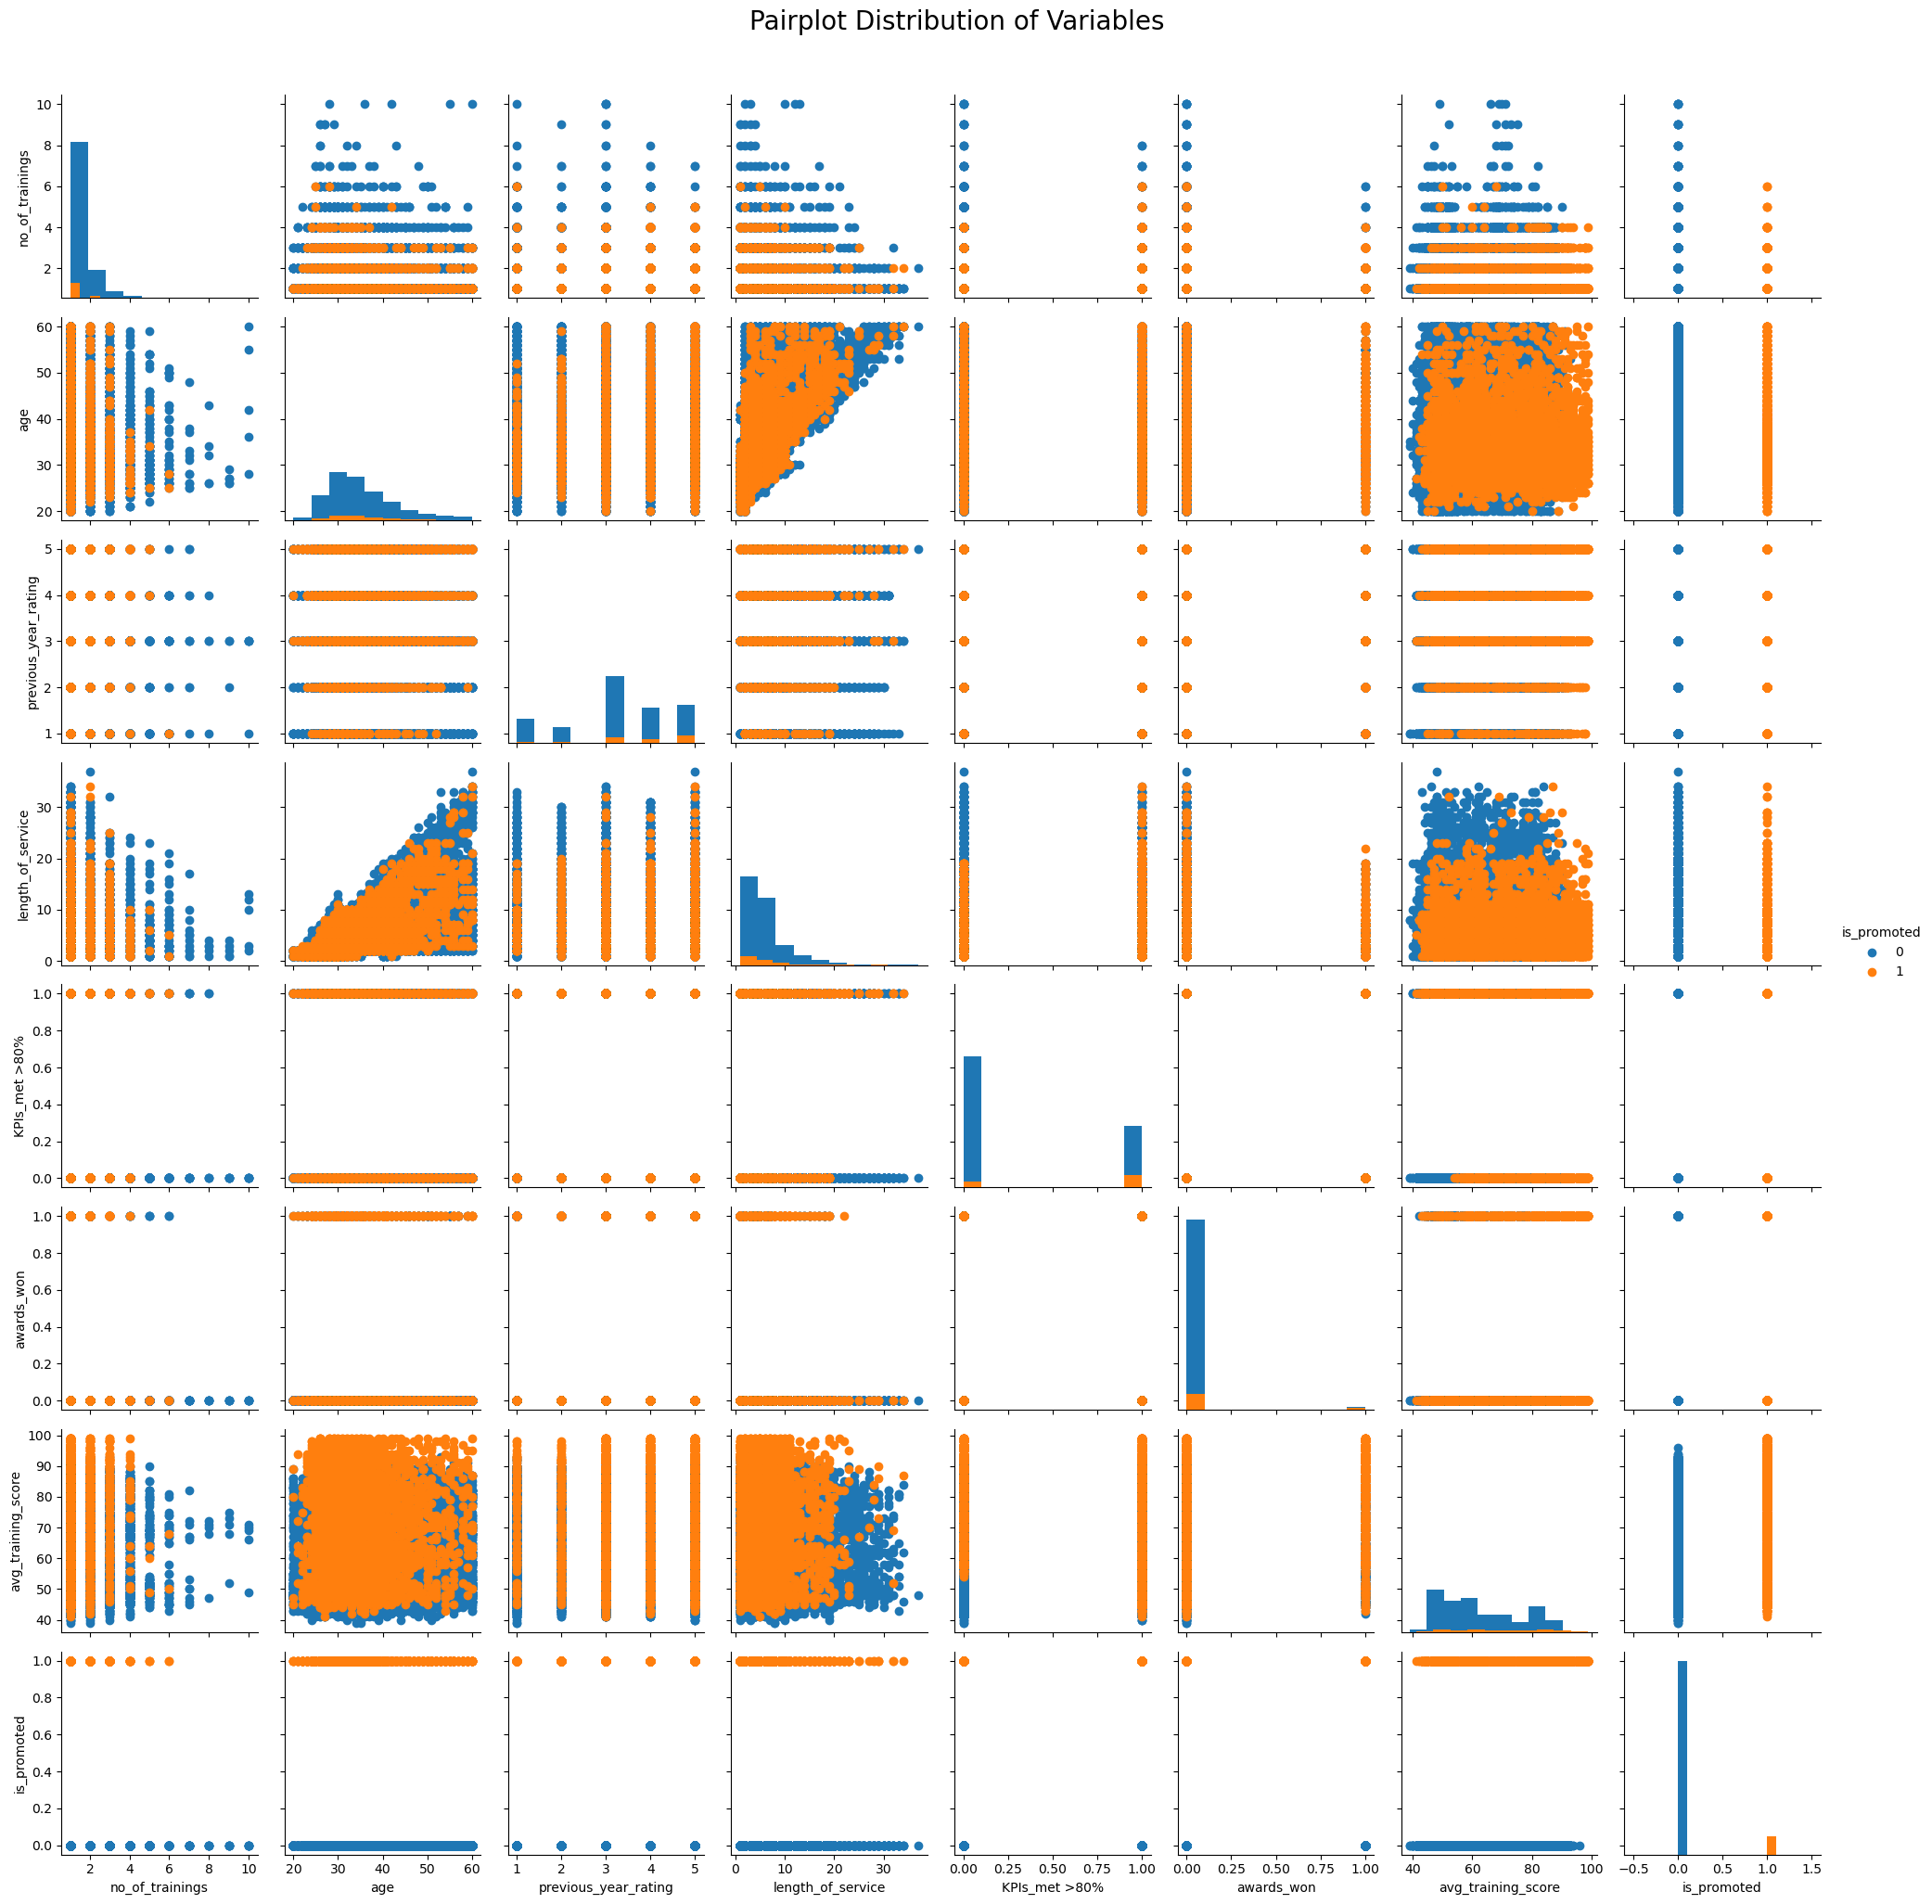

In [27]:
pairgrid = sns.PairGrid(data=hr_dataset, vars=['no_of_trainings', 'age', 'previous_year_rating',
                                'length_of_service', 'KPIs_met >80%', 'awards_won',
                                'avg_training_score', 'is_promoted'],
                 hue='is_promoted')

pairgrid.map_diag(plt.hist)
pairgrid.map_offdiag(plt.scatter)

pairgrid.add_legend()

pairgrid.fig.suptitle('Pairplot Distribution of Variables', y=1.03, fontsize=20)
plt.show()

__Observation:__
* Observed a correlation between length_of_service and age

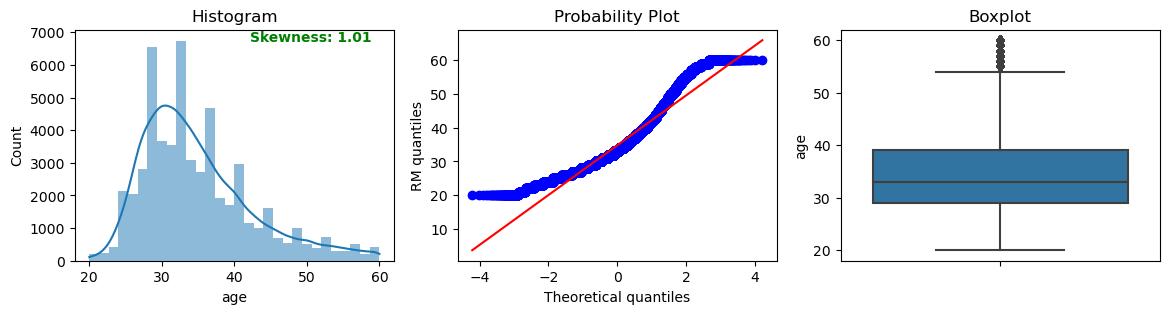

In [28]:
plot_charts_numerical(hr_dataset, 'age')

__Observation:__
* age is right skewed
* Some outliers are present

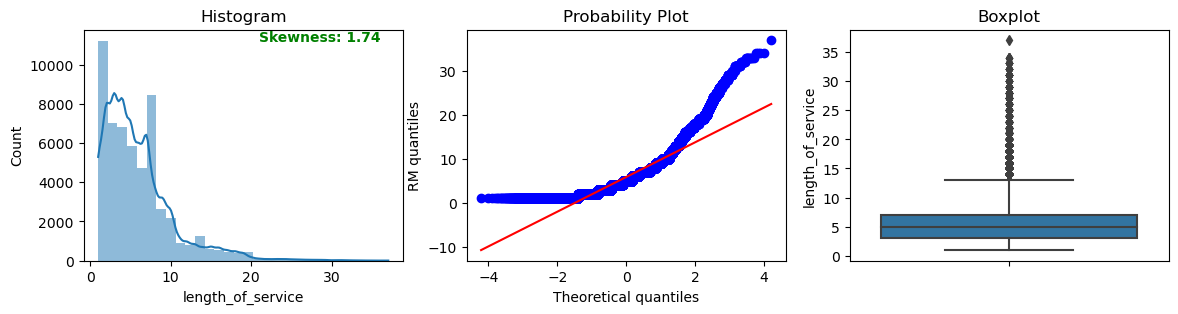

In [29]:
plot_charts_numerical(hr_dataset, 'length_of_service')

__Observation:__
* length_of_service is right skewed
* Many outliers are present

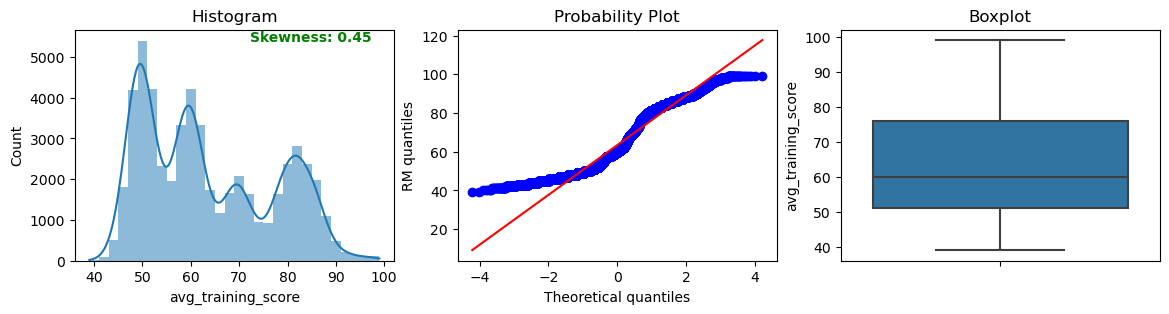

In [30]:
plot_charts_numerical(hr_dataset, 'avg_training_score')

__Observation:__
* avg_training_score is right skewed
* No outliers are present

<a id= "part1.3"></a>
### 1.3 Chi-Square Test for Independence
[Go to Start](#Start)

The __chi-square test__ is a statistical test used to determine whether there is a significant association between categorical variables. In feature selection for machine learning, chi-square tests can help identify relevant features for classification tasks.

__How it Works:__
* __Null Hypothesis:__ Assumes no association between variables (independence).
* __P-value Interpretation:__ If the p-value is below a chosen significance level (usually 0.05), the null hypothesis is rejected, indicating a significant association.

Here, we check significant association between variables __is_promoted__ vs __(awards_won, gender, recruitment_channel, education, region, department, KPIs_met >80%)__.

In [31]:
def create_contingency_table(column_name):
    contingency_table = pd.crosstab(hr_dataset['is_promoted'], hr_dataset[column_name])
    return contingency_table

def perform_chi2_test(table):
    chi2, p, dof, expected = chi2_contingency(table)
    return chi2, p, dof, expected

In [32]:
contingency_department = create_contingency_table('department')
contingency_region = create_contingency_table('region')
contingency_education = create_contingency_table('education')
contingency_gender = create_contingency_table('gender')
contingency_recruitment = create_contingency_table('recruitment_channel')
contingency_KPIsmet = create_contingency_table('KPIs_met >80%')
contingency_awardswon = create_contingency_table('awards_won')

In [33]:
results = {}
results['recruitment_channel'] = perform_chi2_test(contingency_recruitment)
results['gender'] = perform_chi2_test(contingency_gender)
results['education'] = perform_chi2_test(contingency_education)
results['region'] = perform_chi2_test(contingency_region)
results['department'] = perform_chi2_test(contingency_department)
results['awards_won'] = perform_chi2_test(contingency_awardswon)
results['KPIs_met >80%'] = perform_chi2_test(contingency_KPIsmet)

In [34]:
for var, (chi2, p, dof, expected) in results.items():
    print(f"Chi-square test for {var}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies:")
    print(expected)
    print("\n")

Chi-square test for recruitment_channel:
Chi-square statistic: 19.23633518768639
P-value: 6.650937825577018e-05
Degrees of freedom: 2
Expected frequencies:
[[27852.91271347  1044.73580499 21242.35148154]
 [ 2593.08728653    97.26419501  1977.64851846]]


Chi-square test for gender:
Chi-square statistic: 6.677254566546107
P-value: 0.009765091521176657
Degrees of freedom: 1
Expected frequencies:
[[14922.70617428 35217.29382572]
 [ 1389.29382572  3278.70617428]]


Chi-square test for education:
Chi-square statistic: 36.70295913519633
P-value: 1.0716517784616584e-08
Degrees of freedom: 2
Expected frequencies:
[[33487.69360102   735.1603084  13630.14609057]
 [ 3181.30639898    69.8396916   1294.85390943]]


Chi-square test for region:
Chi-square statistic: 475.64023775792066
P-value: 7.275378205784026e-80
Degrees of freedom: 33
Expected frequencies:
[[5.58046271e+02 5.92809809e+02 1.20300139e+03 4.57414976e+02
  2.42246971e+03 7.56564370e+02 2.56884250e+03 1.34022588e+03
  7.28204642e+02 2.

__Observation:__
* I observed that the significant association between the categorical variables __is_promoted__ and the following factors: __awards_won, gender, recruitment_channel, education, region, department, KPIs_met >80%__, with a p-value < 0.05.
* This test basically said all the categorical features are important and this test may be unreliable as well so further test has to be done later on

<a id= "part1.4"></a>
### 1.4 Missing Value Imputation
[Go to Start](#Start)

In [35]:
hr_dataset.isnull().sum().sort_values(ascending=False)

previous_year_rating    4124
education               2409
employee_id                0
department                 0
region                     0
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
length_of_service          0
KPIs_met >80%              0
awards_won                 0
avg_training_score         0
is_promoted                0
dtype: int64

In [36]:
previous_year_rating_null = hr_dataset[hr_dataset['previous_year_rating'].isnull()]
previous_year_rating_null[['previous_year_rating','length_of_service']]

previous_year_rating  length_of_service
10                      NaN                  1
23                      NaN                  1
29                      NaN                  1
56                      NaN                  1
58                      NaN                  1
...                     ...                ...
54703                   NaN                  1
54734                   NaN                  1
54746                   NaN                  1
54773                   NaN                  1
54801                   NaN                  1

[4124 rows x 2 columns]

__Observation:__

This can be interpreted to mean that workers with only 1 year of service to the firm have missing values for previous_year_rating because they were not part of the firm in the previous year.

In [37]:
hr_dataset['previous_year_rating'].fillna(0, inplace=True)
hr_dataset['education'].fillna('Missing', inplace=True)

This is how I carried out __Missing Value Imputation__:<br><br>
__education__
> Due to the significant number of null values for education, I used imputation methods such that they are able to capture the value "Missing". This would not only not distort the natural distribution too much due to number of null values that exist, but allow our machine learning or prediction models to have a distinction between those null values compared to using a imputation method such as those based on frequency which may distort it and worsen the models ability to identify effective relationships between those values, allowing the machine learning algorithms to establish a relationship between "regular" values and null values.
    
__previous_year_rating__
> Since previous_year_rating is null only when the length_of_service of the employee is 1, this means that the employee just joined the firm and he could not have a rating of last year as he/she was not present in the company last year. Therefore, I replaced the null values to 0 to indicate that those who joined the company newly will start with a rating of 0.

In [38]:
hr_dataset.isnull().sum().sort_values(ascending=False)

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won              0
avg_training_score      0
is_promoted             0
dtype: int64

In [39]:
rating_counts = hr_dataset.groupby(['previous_year_rating', 'is_promoted']).size().unstack(fill_value=0)
rating_counts = rating_counts.reset_index()

rating_counts['Total'] = rating_counts[0] + rating_counts[1]

rating_counts['Not Promoted'] = rating_counts[0] / rating_counts['Total']
rating_counts['Promoted'] = rating_counts[1] / rating_counts['Total']

fig = px.bar(rating_counts, x='previous_year_rating', y=['Not Promoted', 'Promoted'],
             title='Proportion of Promoted Employees by Previous Year Rating',
             labels={'previous_year_rating': 'Previous Year Rating', 'value': 'Proportion', 'variable': 'Promoted'},
             barmode='group')

fig.update_layout(yaxis=dict(tickformat=".0%"))
fig.show()

<a id= "part1.5"></a>
### 1.5 Numerical Transformation
[Go to Start](#Start)

In [40]:
def transformation_processor(feature, method, exp=None):

    if method == "log": transformer= LogTransformer(variables= feature)
    elif method == "rec": transformer= ReciprocalTransformer(variables= feature)
    elif method == "power": transformer= PowerTransformer(variables= feature, exp= exp)
    elif method == "box": transformer= BoxCoxTransformer(variables= feature)
    elif method == "yeo": transformer= YeoJohnsonTransformer(variables= feature)

    transformer.fit(hr_dataset)
    trans_testing_set= transformer.transform(hr_dataset)
    
    return trans_testing_set

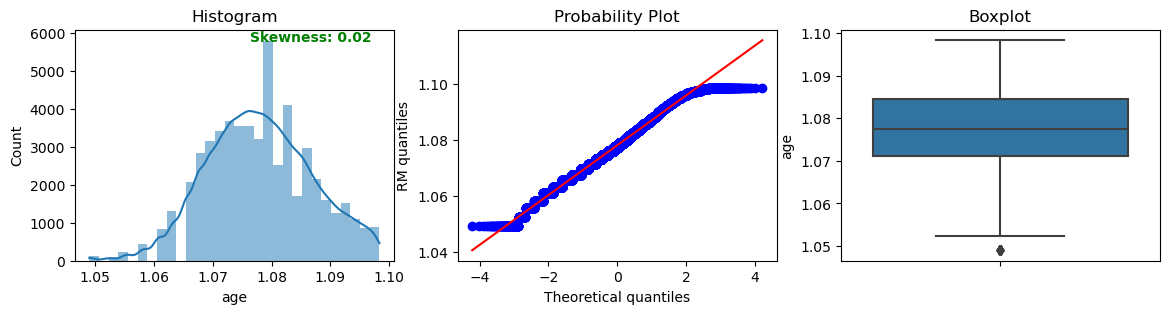

In [41]:
trans_testing_set= transformation_processor('age', 'box')
plot_charts_numerical(trans_testing_set, 'age')

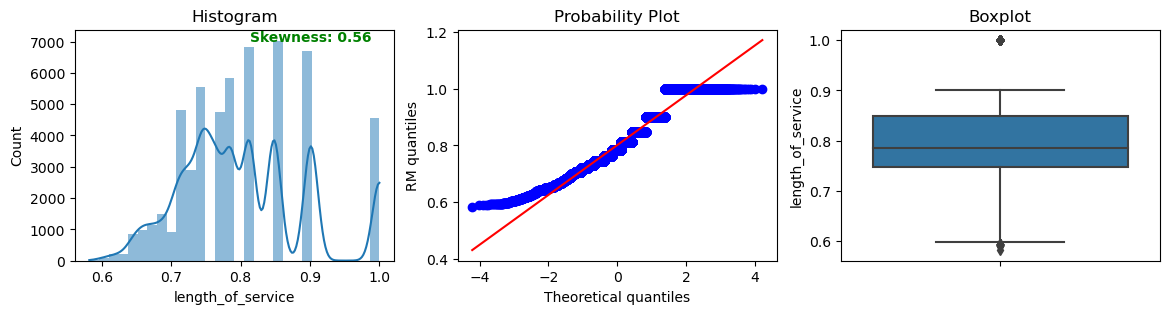

In [42]:
trans_testing_set= transformation_processor('length_of_service', 'power', exp=-0.15)
plot_charts_numerical(trans_testing_set, 'length_of_service')

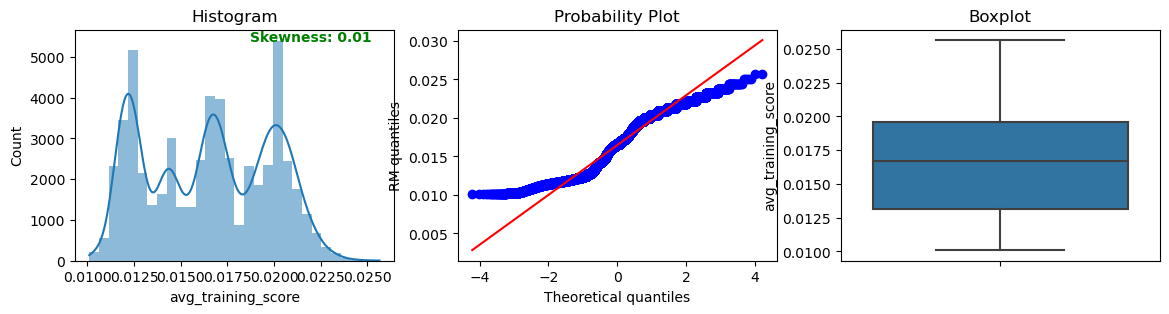

In [43]:
trans_testing_set= transformation_processor('avg_training_score', 'rec')
plot_charts_numerical(trans_testing_set, 'avg_training_score')

In [44]:
# numerical_transformation_pipe= Pipeline(steps=[
#     ('boxcox_trans', BoxCoxTransformer(variables= ['age'])),
#     ('power_trans', PowerTransformer(variables= ['length_of_service'], exp= -0.15)),
#     ('rec_trans', ReciprocalTransformer(variables= ['avg_training_score'])),
# ])

# numerical_transformation_pipe.fit(hr_dataset)
# hr_dataset= numerical_transformation_pipe.transform(hr_dataset)

Numerical Transformation was __not done__ as transforming these variables might potentially distort or alter the original information. Age, length of service and avg_training_score hold specific, precise values that convey essential aspects of an employee's profile, and changing these values through transformations could lead to losing the original context and accuracy.

Unlike some variables that might require transformation due to skewed distributions or scale issues, these variables here are straightforward numeric measures that directly convey relevant information without needing transformation.

<a id= "part1.6"></a>
### 1.6 Categorical Data Encoding
[Go to Start](#Start)

In [45]:
encoding_transformation_pipe= Pipeline(steps=[
    ('dummy_enc', OneHotEncoder(variables= ['education', 'gender', 'department', 'recruitment_channel'], drop_last= False)),
    ('ordinal_enc', OrdinalEncoder(variables= ['region'], encoding_method= "ordered"))
])

__Encoding methods chosen:__<br><br>

__region:__<br>
Ordered Ordinal Encoding
> There seem to be a natural order to the region. Due to this nature forming a ordinal relationship, I decided to use ordinal encoding for this feature. Moreover, doing one hot encoding could lead to problems as it will result in curse of dimensionality as this column has a high cardinality.

__recruitment_channel:__<br>
Dummy Encoding
> The values that make up the cardinality of this feature is low enough that One Hot Encoding is less likely to lead to the curse of dimensionality.

__gender:__<br>
Dummy Encoding
> The cardinality of this feature is only 2. This seems perfect for a binary representation of the values such as 0 meaning the gender is male else if it is 1, it means female.

__education:__<br>
Dummy Encoding
> The values that make up the cardinality of this feature seems to be very distinct and low enough that One Hot Encoding is less likely to lead to the curse of dimensionality.

__department:__<br>
Dummy Encoding
> I want to preserve the distinction between different departments as this column is important and therefore I did one hot encoding as it removes bias by creating separate columns, ensuring equal importance for each category. Moreover, the cardinality of this column is 9 and this is not too much that it will cause curse of dimensionality.

In [46]:
target_column = hr_dataset['is_promoted']
encoding_transformation_pipe.fit(hr_dataset.drop(labels=['is_promoted'], axis=1), target_column)
hr_dataset = encoding_transformation_pipe.transform(hr_dataset.drop(labels=['is_promoted'], axis=1))

In [47]:
hr_dataset = pd.concat([hr_dataset, target_column], axis=1)

In [48]:
hr_dataset

employee_id  region  no_of_trainings  age  previous_year_rating  \
0            65438      26                1   35                   5.0   
1            65141      28                1   30                   5.0   
2             7513      13                1   34                   3.0   
3             2542      29                2   39                   1.0   
4            48945      14                1   45                   3.0   
...            ...     ...              ...  ...                   ...   
54803         3030      17                1   48                   3.0   
54804        74592      19                1   37                   2.0   
54805        13918      25                1   27                   5.0   
54806        13614       0                1   29                   1.0   
54807        51526      28                1   27                   1.0   

       length_of_service  KPIs_met >80%  awards_won  avg_training_score  \
0                      8              1           0                  49   
1                      4              0           0                  60   
2                      7              0           0                  50   
3                     10              0           0                  50   
4                      2              0           0                  73   
...                  ...            ...         ...                 ...   
54803                 17              0           0                  78   
54804                  6              0           0                  56   
54805                  3              1           0                  79   
54806                  2              0           0                  45   
54807                  5              0           0                  49   

       education_Master's & above  ...  department_Analytics  department_R&D  \
0                               1  ...                     0               0   
1                               0  ...                     0               0   
2                               0  ...                     0               0   
3                               0  ...                     0               0   
4                               0  ...                     0               0   
...                           ...  ...                   ...             ...   
54803                           0  ...                     0               0   
54804                           1  ...                     0               0   
54805                           0  ...                     1               0   
54806                           0  ...                     0               0   
54807                           0  ...                     0               0   

       department_Procurement  department_Finance  department_HR  \
0                           0                   0              0   
1                           0                   0              0   
2                           0                   0              0   
3                           0                   0              0   
4                           0                   0              0   
...                       ...                 ...            ...   
54803                       0                   0              0   
54804                       0                   0              0   
54805                       0                   0              0   
54806                       0                   0              0   
54807                       0                   0              1   

       department_Legal  recruitment_channel_sourcing  \
0                     0                             1   
1                     0                             0   
2                     0                             1   
3                     0                             0   
4                     0                             0   
...                 ...                           ...   
54803                 0                 

In [49]:
region = hr_dataset.groupby('region')['is_promoted'].mean().reset_index()

fig = px.line(region, x='region', y='is_promoted', 
              title='Proportion of Promoted Employees by Region',
              labels={'region_number': 'Region Number', 'is_promoted': 'Proportion Promoted'})

fig.show()

This Ordered Ordinal Encoding technique creates a monotonic relationship between the region and the target variable which is 'is_promoted' and therefore makes region more adequate for use in linear models.

<a id= "part1.7"></a>
### 1.7 Correlation Analysis
[Go to Start](#Start)

Correlation refers to a statistical measure that describes the strength and direction of a relationship between two variables. It assesses how changes in one variable are associated with changes in another variable. In data analysis and modeling, correlation helps identify which variables are strongly related, aiding in feature selection for predictive models.

__How it Works:__

* __Positive Correlation:__ When one variable increases, the other tends to increase as well (correlation coefficient close to +1).
* __Negative Correlation:__ When one variable increases, the other tends to decrease (correlation coefficient close to -1).
* __No Correlation:__ When there's no discernible relationship between the variables (correlation coefficient close to 0).

Here, we will check correlation between the variables for redundency. 

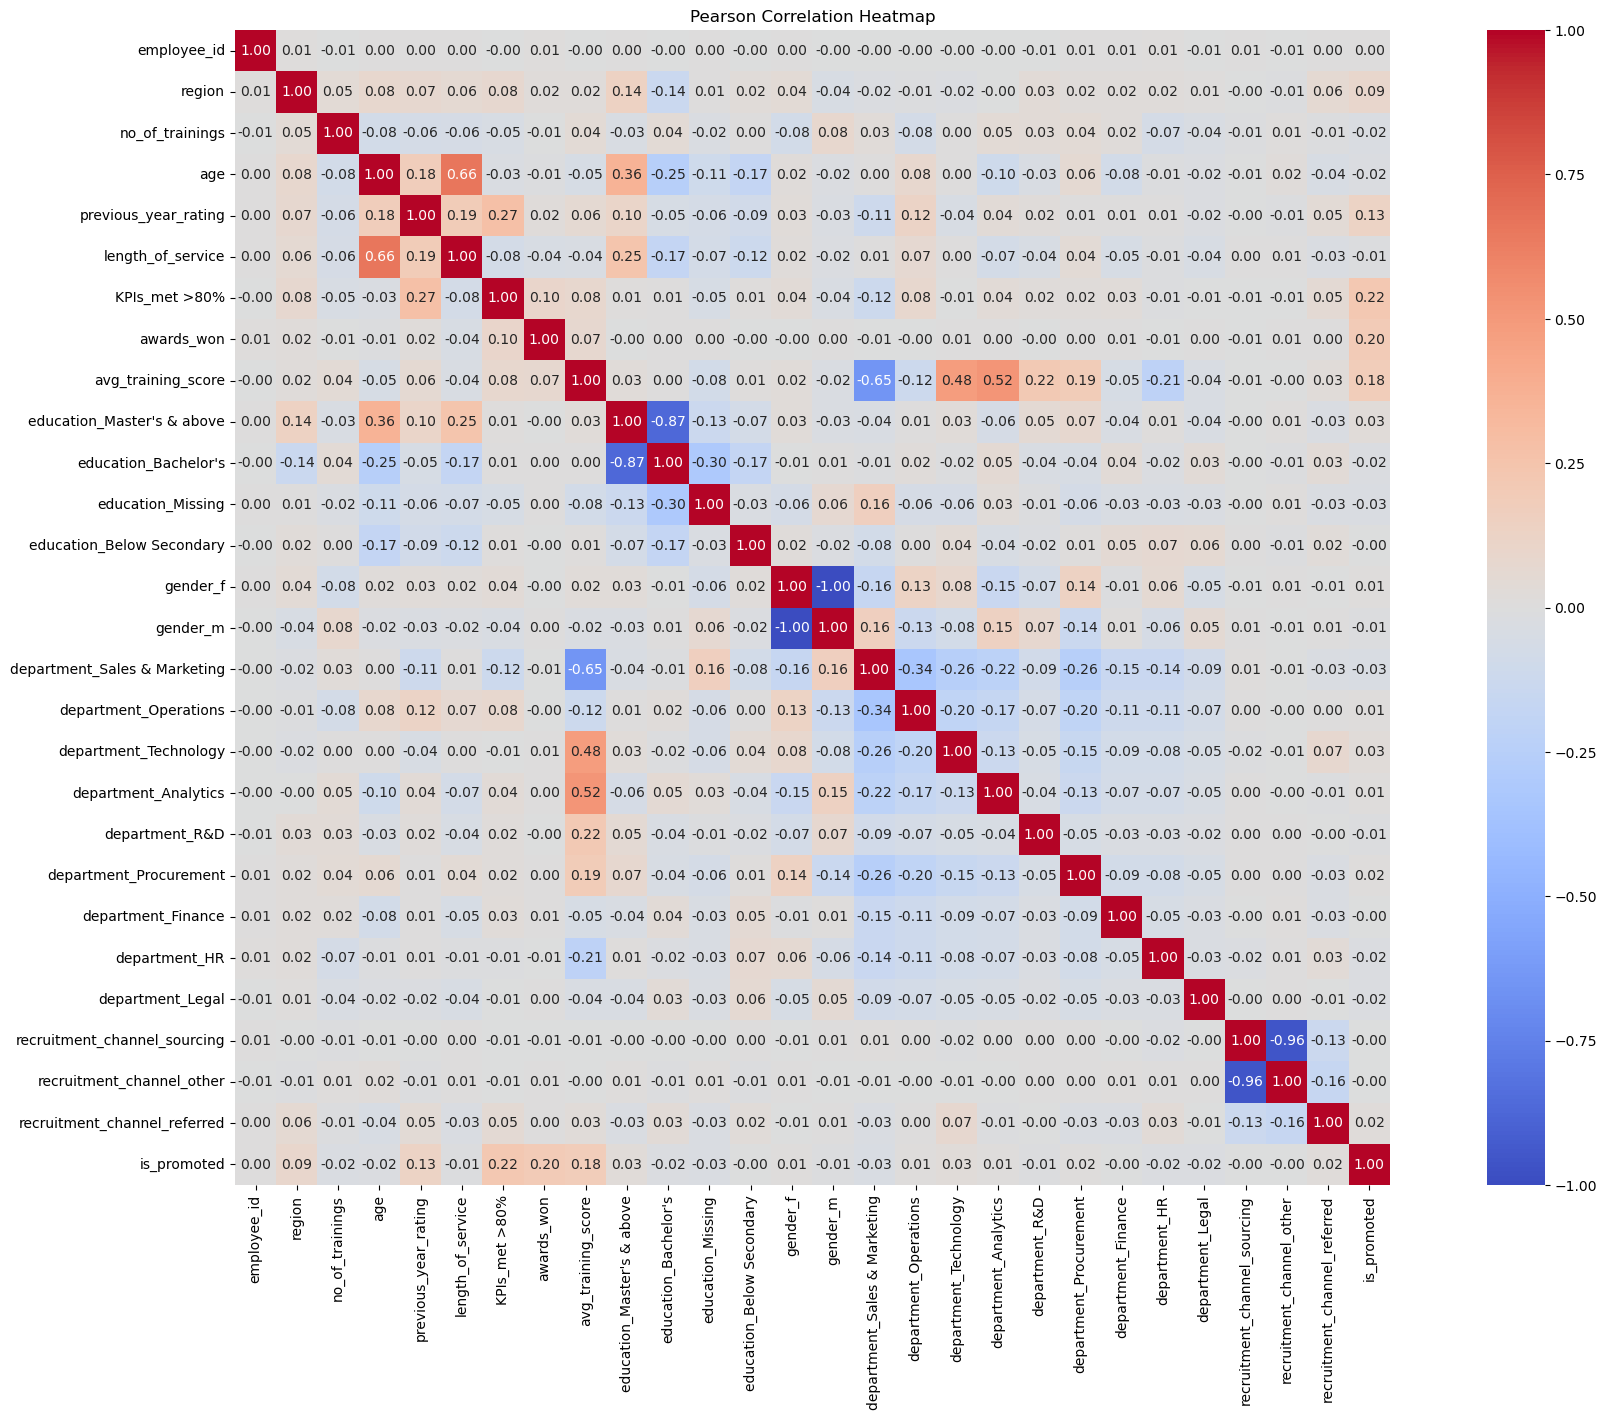

In [50]:
correlation_matrix = hr_dataset.corr()

plt.figure(figsize=(25,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Pearson Correlation Heatmap')
plt.show()

__Observation:__
- Some significant correlation between the features and the target variable:
> - region <br>
> - previous_year_rating<br>
> - KPIs_met >80%<br>
> - awards_won<br>
> - avg_training_score<br>

<a id= "part1.8"></a>
### 1.8 Feature Selection
[Go to Start](#Start)

In [51]:
hr_dataset.drop(columns=['employee_id'], inplace=True)

In [52]:
lg2 = sm.Logit(hr_dataset["is_promoted"], hr_dataset.drop('is_promoted',axis=1)).fit()
lg2.summary()

Optimization terminated successfully.
         Current function value: 0.197276
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_promoted   No. Observations:                54808
Model:                          Logit   Df Residuals:                    54785
Method:                           MLE   Df Model:                           22
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.3226
Time:                        18:28:39   Log-Likelihood:                -10812.
converged:                       True   LL-Null:                       -15961.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
region                           0.0412      0.003     15.328      0.000       0.036       0.047
no_of_trainings                 -0.1368      0.035     -3.930      0.000      -0.205      -0.069
age                             -0.0308      0.004     -8.614      0.000      -0.038      -0.024
previous_year_rating             0.1507      0.014     11.074      0.000       0.124       0.177
length_of_service                0.0243      0.006      4.019      0.000       0.012       0.036
KPIs_met >80%                    1.9219      0.044     43.908      0.000       1.836       2.008
awards_won                       1.4549      0.079     18.457      0.000       1.300       1.609
avg_training_score               0.3090      0.005     60.195      0.000       0.299       0.319
education_Master's & above      -5.0214        nan        nan        nan         nan         nan
education_Bachelor's            -5.1711        nan        nan        nan         nan         nan
education_Missing               -5.5855        nan        nan        nan         nan         nan
education_Below Secondary       -5.2185        nan        nan        nan         nan         nan
gender_f                       -10.5156   1.24e+06  -8.45e-06      1.000   -2.44e+06    2.44e+06
gender_m                       -10.4810   1.22e+06  -8.59e-06      1.000   -2.39e+06    2.39e+06
department_Sales & Marketing     2.8716   1.37e+06    2.1e-06      1.000   -2.68e+06    2.68e+06
department_Operations           -0.2939   1.32e+06  -2.23e-07      1.000   -2.59e+06    2.59e+06
department_Technology           -5.8986   1.58e+06  -3.74e-06      1.000   -3.09e+06    3.09e+06
department_Analytics            -7.6419   1.66e+06   -4.6e-06      1.000   -3.26e+06    3.26e+06
department_R&D                  -8.1577   1.67e+06  -4.88e-06      1.000   -3.28e+06    3.28e+06
department_Procurement          -3.1924   1.63e+06  -1.96e-06      1.000   -3.19e+06    3.19e+06
department_Finance              -0.4885   1.49e+06  -3.29e-07      1.000   -2.91e+06    2.91e+06
department_HR                    2.4532   1.54e+06   1.59e-06      1.000   -3.03e+06    3.03e+06
department_Legal                -0.6483   1.29e+06  -5.04e-07      1.000   -2.52e+06    2.52e+06
recruitment_channel_sourcing    -6.9625        nan        nan        nan         nan         nan
recruitment_channel_other       -6.9503        nan        nan        nan         nan         nan
recruitment_channel_referred    -7.0838        nan        nan        nan         nan         nan
================================================================================================
"""

__Observation:__
- From the above model summary, we can see that `region`, `no_of_trainings`, `age`, `previous_year_rating`, `length_of_service`, `KPIs_met >80%	`, `awards_won` and `avg_training_score	` have a ZERO **p-value** (i.e. the column `P>|z|`). It means that there is a very high confidence on the coefficients of these features, or say these features are the most strong indicators to predict `is_promoted`. 

- On the other hand, the rest of the columns have either a **p-value** of 1 or nan

- Therefore, utilizing this method to find important features is not helpful and therfore I have to find other ways to carry out feature selection

In [53]:
X = hr_dataset.drop(columns=['is_promoted'], axis=1)
y = hr_dataset['is_promoted']

In [54]:
from sklearn.feature_selection import chi2

chi_scores = chi2(X, y)
chi_scores

(array([1.23149069e+03, 1.00634908e+01, 2.72281031e+01, 6.32801485e+02,
        1.93510843e+01, 1.74382712e+03, 2.05400931e+03, 5.07297374e+03,
        3.43407938e+01, 4.63690350e+00, 3.68568194e+01, 3.88935029e-02,
        4.75090750e+00, 2.01311313e+00, 3.73121811e+01, 3.60911787e+00,
        4.60618282e+01, 7.56595864e+00, 3.32386053e+00, 1.15235447e+01,
        5.05198966e-01, 2.59646398e+01, 1.55600253e+01, 7.35772605e-03,
        5.79819221e-01, 1.86491582e+01]),
 array([8.74113401e-270, 1.51236397e-003, 1.80811304e-007, 1.22892732e-139,
        1.08757475e-005, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        4.62583334e-009, 3.12914140e-002, 1.27130637e-009, 8.43659795e-001,
        2.92828475e-002, 1.55945032e-001, 1.00653947e-009, 5.74635924e-002,
        1.14579286e-011, 5.94810081e-003, 6.82813146e-002, 6.87202278e-004,
        4.77224606e-001, 3.47728427e-007, 7.99266894e-005, 9.31643541e-001,
        4.46383189e-001, 1.57116625e-005]))

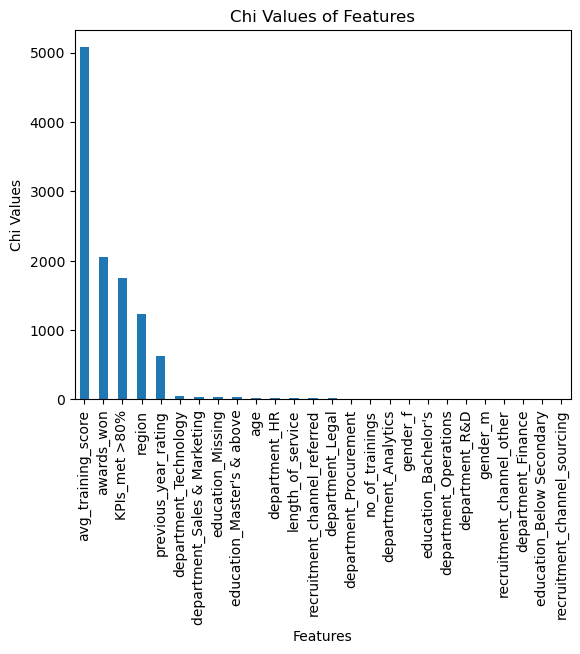

In [55]:
chi_values = pd.Series(chi_scores[0], index = X.columns)
chi_values.sort_values(ascending = False, inplace = True)
chi_values.plot.bar()
plt.title('Chi Values of Features')
plt.xlabel('Features')
plt.ylabel('Chi Values')
plt.show()

__Observation:__
- The higher the chi value, the higher the importance of the feature
- `avg_training_score`, `awards_won`, `KPIs_met >80%`, `region`, `previous_year_rating` seem to have a high importance 
- `recruitment_channel_sourcing`, `education_Below Secondary`, `department_Finance`, `recruitment_channel_other`, `gender_m` are features that have low importance

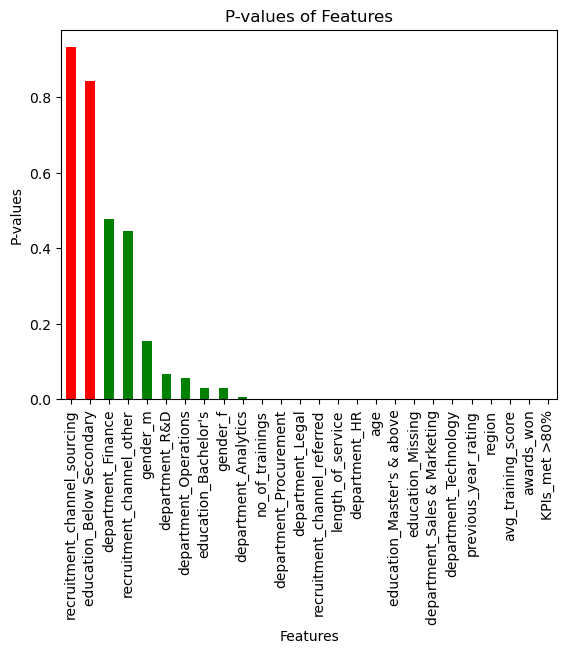

In [56]:
# if p-value > 0.5, lower the importance
p_values = pd.Series(chi_scores[1], index = X.columns)
p_values.sort_values(ascending= False, inplace = True)

colors = ['red' if val > 0.5 else 'green' for val in p_values]
p_values.plot.bar(color=colors)
plt.title('P-values of Features')
plt.xlabel('Features')
plt.ylabel('P-values')
plt.show()

__Observation:__
- If p-value > 0.5, it means the feature has low importance
- `recruitment_channel_sourcing`, `education_Below Secondary` has p-value above 0.5 meaning these columns are of low importance
- `department_Finance`, `recruitment_channel_other` has a p-value of close to 0.5 so these features may also be of lower importance

In [57]:
fs = SelectKBest(score_func=f_classif, k=10)
fs.fit(X, y)

features_score = pd.DataFrame(fs.scores_)
features_pvalue = pd.DataFrame(np.round(fs.pvalues_,6))
features = pd.DataFrame(X.columns)
feature_score = pd.concat([features, features_score, features_pvalue], axis=1)
feature_score.columns = ['Input Feature', 'Score', 'P-Value']

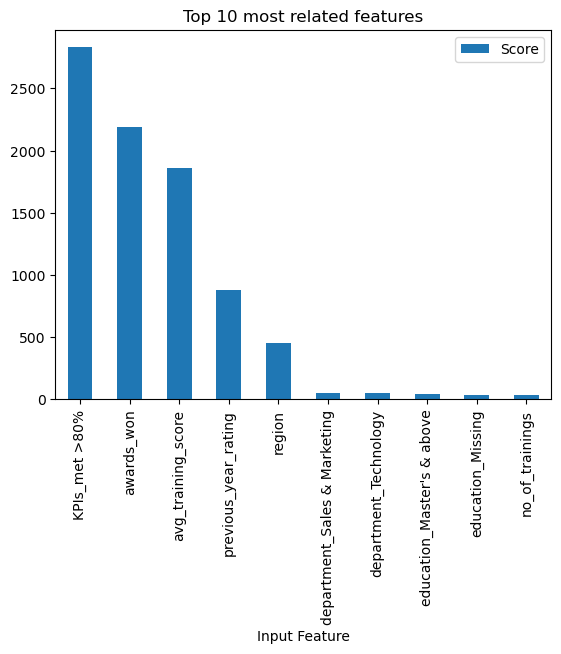

In [58]:
most_related_features_by_score = feature_score.nlargest(10,'Score')
most_related_features_by_score.plot.bar(x='Input Feature', y='Score', rot=90)
plt.title('Top 10 most related features')
plt.show()

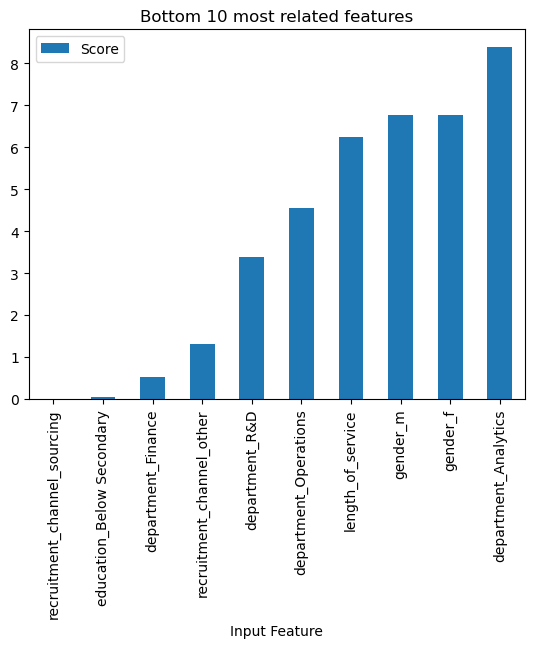

In [59]:
least_related_features_by_score = feature_score.nsmallest(10, 'Score')
least_related_features_by_score.plot.bar(x='Input Feature', y='Score', rot=90)
plt.title('Bottom 10 most related features')
plt.show()

In [60]:
hr_dataset.drop(columns=['education_Below Secondary', 'department_Finance', 'recruitment_channel_sourcing'], inplace=True)

I removed these 3 columns as these columns will not help the target variable based on the tests I did above.

<a id= "part1.9"></a>
### 1.9 Feature Scaling
[Go to Start](#Start)

In [61]:
target_column = hr_dataset['is_promoted']

scaler = StandardScaler()
scaler.fit(hr_dataset.drop(labels=['is_promoted'], axis=1))
hr_dataset_scaled = scaler.transform(hr_dataset.drop(labels=['is_promoted'], axis=1))

hr_dataset_scaled = pd.DataFrame(hr_dataset_scaled, columns=(hr_dataset.drop(labels=['is_promoted'], axis=1)).columns)
hr_dataset_scaled = pd.concat([hr_dataset_scaled, target_column], axis=1)

__Reason to do Scaling:__
- Even though logistic regression is less sensitive to feature scaling compared to some other algorithms, scaling features can still be advantageous

>Feature scaling can help the optimization algorithm converge more quickly. Gradient-based optimization methods, like those used in logistic regression, can converge faster when features are on a similar scale.

>When features are on different scales, the coefficients become challenging to interpret since a unit change in one feature might have a different effect compared to a unit change in another feature. Feature scaling helps in making these coefficients comparable and interpretable.

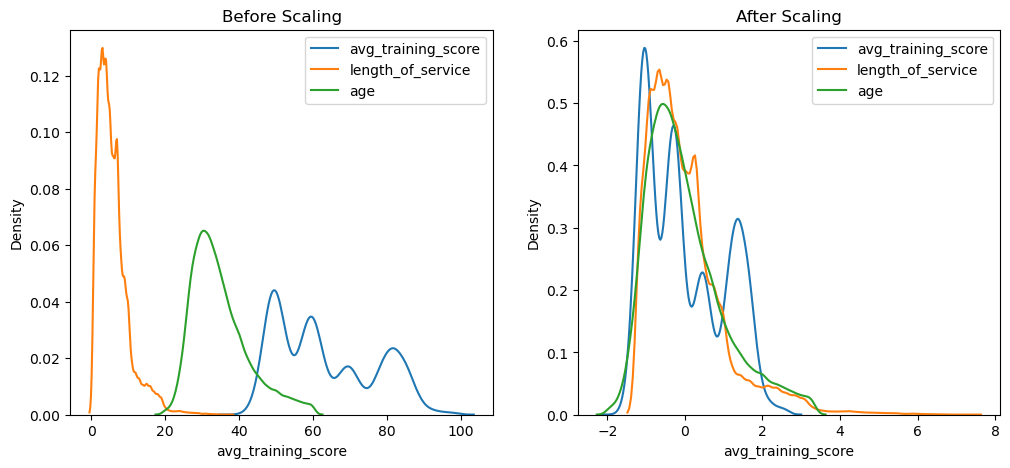

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(hr_dataset['avg_training_score'], ax=ax1, label ='avg_training_score')
sns.kdeplot(hr_dataset['length_of_service'], ax=ax1, label ='length_of_service')
sns.kdeplot(hr_dataset['age'], ax=ax1, label ='age')
ax1.legend()

# after scaling
ax2.set_title('After Scaling')
sns.kdeplot(hr_dataset_scaled['avg_training_score'], ax=ax2, label ='avg_training_score')
sns.kdeplot(hr_dataset_scaled['length_of_service'], ax=ax2, label ='length_of_service')
sns.kdeplot(hr_dataset_scaled['age'], ax=ax2, label ='age')
ax2.legend()
plt.show()

hr_dataset = hr_dataset_scaled

In [63]:
hr_dataset

region  no_of_trainings       age  previous_year_rating  \
0      0.738267        -0.415276  0.025598              1.283878   
1      1.005601        -0.415276 -0.627135              1.283878   
2     -0.999402        -0.415276 -0.104948             -0.052623   
3      1.139268         1.226063  0.547785             -1.389124   
4     -0.865735        -0.415276  1.331064             -0.052623   
...         ...              ...       ...                   ...   
54803 -0.464734        -0.415276  1.722704             -0.052623   
54804 -0.197401        -0.415276  0.286691             -0.720874   
54805  0.604601        -0.415276 -1.018775              1.283878   
54806 -2.737071        -0.415276 -0.757681             -1.389124   
54807  1.005601        -0.415276 -1.018775             -1.389124   

       length_of_service  KPIs_met >80%  awards_won  avg_training_score  \
0               0.500460       1.356878   -0.154018           -1.075931   
1              -0.437395      -0.736986   -0.154018           -0.253282   
2               0.265996      -0.736986   -0.154018           -1.001145   
3               0.969387      -0.736986   -0.154018           -1.001145   
4              -0.906322      -0.736986   -0.154018            0.718939   
...                  ...            ...         ...                 ...   
54803           2.610632      -0.736986   -0.154018            1.092871   
54804           0.031532      -0.736986   -0.154018           -0.552428   
54805          -0.671858       1.356878   -0.154018            1.167657   
54806          -0.906322      -0.736986   -0.154018           -1.375077   
54807          -0.202931      -0.736986   -0.154018           -1.075931   

       education_Master's & above  education_Bachelor's  ...  \
0                        1.634695             -1.421814  ...   
1                       -0.611735              0.703327  ...   
2                       -0.611735              0.703327  ...   
3                       -0.611735              0.703327  ...   
4                       -0.611735              0.703327  ...   
...                           ...                   ...  ...   
54803                   -0.611735              0.703327  ...   
54804                    1.634695             -1.421814  ...   
54805                   -0.611735              0.703327  ...   
54806                   -0.611735             -1.421814  ...   
54807                   -0.611735              0.703327  ...   

       department_Operations  department_Technology  department_Analytics  \
0                  -0.510993              -0.386960             -0.328964   
1                   1.956975              -0.386960             -0.328964   
2                  -0.510993              -0.386960             -0.328964   
3                  -0.510993              -0.386960             -0.328964   
4                  -0.510993               2.584249             -0.328964   
...                      ...                    ...                   ...   
54803              -0.510993               2.584249             -0.328964   
54804               1.956975              -0.386960             -0.328964   
54805              -0.510993              -0.386960              3.039845   
54806              -0.510993              -0.386960             -0.328964   
54807              -0.510993              -0.386960             -0.328964   

       department_R&D  department_Procurement  department_HR  \
0           -0.136256                -0.38696      -0.214834   
1           -0.136256                -0.38696      -0.214834   
2           -0.136256                -0.38696      -0.214834   
3           -0.136256                -0.38696      -0.214834   
4           -0.136256                -0.38696      -0.214834   
...               ...                     ...            ...   
54803       -0.136256                -0.38696      -0.214834   
54804       -0.136256                -0.38696      -0.214834   
54805       -0.136256

<a id= "part1.10"></a>
### 1.10 Stratified Sampling
[Go to Start](#Start)

In [64]:
hr_dataset_without_sampling = hr_dataset

df1 = hr_dataset[hr_dataset['is_promoted']==1]
df0 = hr_dataset[hr_dataset['is_promoted']==0]
df0_sampled = df0.sample(n=len(df1), random_state=2).copy()

In [65]:
hr_dataset=pd.concat([df1,df0_sampled],axis=0)
hr_dataset['is_promoted'].value_counts()

1    4668
0    4668
Name: is_promoted, dtype: int64

In [66]:
hr_dataset.shape

(9336, 24)

At the start of the report I mentioned that the target variable is imbalanced and this is not suitable when creating a logistic regression model. Therefore, I have downsampled the data and reduced the columns from 54808 to 9336. Now the data in the target variable is balanced and it is now more suitable to create the model.